In [1]:
import utils
import pandas as pd
import plotly.express as px
from umap import UMAP

color_discrete_map = {'Compound': 'rgb(0,114,178)',
                      'CRISPR': 'rgb(213,94,0)',
                      'ORF': 'rgb(0,158,115)'}

In [2]:
batches = ["2020_11_04_CPJUMP1",
           "2020_11_18_CPJUMP1_TimepointDay1",
           "2020_11_19_TimepointDay4",
           "2020_12_02_CPJUMP1_2WeeksTimePoint",
           "2020_12_07_CPJUMP1_4WeeksTimePoint",
           "2020_12_08_CPJUMP1_Bleaching"
           ]

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
)

In [3]:
# Read all the plates

all_plates_df = pd.DataFrame()
for batch in batches:
    batches_df = experiment_df.query("Batch==@batch")
    for modality in batches_df.Perturbation.unique():
        modality_df = batches_df.query("Perturbation==@modality")
        for cell in modality_df.Cell_type.unique():
            cell_df = modality_df.query('Cell_type==@cell')
            for time_point in cell_df.Time.unique():
                time_df = cell_df.query("Time==@time_point")
                for plate in time_df.Assay_Plate_Barcode.unique():
                    cell_line = time_df.loc[time_df.Assay_Plate_Barcode==plate, "Cell_line"].values[0]
                    time_delay = time_df.loc[time_df.Assay_Plate_Barcode==plate, "Time_delay"].values[0]
                    times_imaged = time_df.loc[time_df.Assay_Plate_Barcode==plate, "Times_imaged"].values[0]
                    density = time_df.loc[time_df.Assay_Plate_Barcode==plate, "Density"].values[0]
                    antibiotics = time_df.loc[time_df.Assay_Plate_Barcode==plate, "Antibiotics"].values[0]
                    data_df = (
                        utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                        .assign(Metadata_modality=modality)
                        .assign(Metadata_cell=cell)
                        .assign(Metadata_time=utils.time_point(modality, time_point))
                        .assign(Metadata_cell_line=cell_line)
                        .assign(Metadata_time_delay=time_delay)
                        .assign(Metadata_times_imaged=times_imaged)
                        .assign(Metadata_density=density)
                        .assign(Metadata_antibiotics=antibiotics)
                    )
                    all_plates_df = utils.concat_profiles(all_plates_df, data_df)

all_plates_df = utils.remove_negcon_empty_wells(all_plates_df)

In [4]:
# UMAP

X = utils.get_featuredata(all_plates_df)

umap_2d = UMAP(n_components=2, random_state=9000)
projection_2d = umap_2d.fit_transform(X)

modality_list = list(all_plates_df.Metadata_modality)
cell_list = list(all_plates_df.Metadata_cell)
time_list = list(all_plates_df.Metadata_time)
cell_line_list = list(all_plates_df.Metadata_cell_line)
time_delay_list = list(all_plates_df.Metadata_time_delay)
times_imaged_list = list(all_plates_df.Metadata_times_imaged)
density_list = list(all_plates_df.Metadata_density)
antibiotics_list = list(all_plates_df.Metadata_antibiotics)

X_embedded_df = pd.DataFrame({'Modality': modality_list,
                              'time': time_list,
                              'Cell': cell_list,
                              'Cell_line': cell_line_list,
                              'Days': time_delay_list,
                              'Times_imaged': times_imaged_list,
                              'Density': density_list,
                              'Antibiotics': antibiotics_list,
                              'umap 1': projection_2d[:,:1].flatten(),
                              'umap 2': projection_2d[:,1:2].flatten()})


In [5]:
X_embedded_df = (
    X_embedded_df.sample(frac=1).reset_index(drop=True)
    .replace({'compound':'Compound',
              'crispr':'CRISPR',
              'orf':'ORF',
              'Day0':0,
              'Day1':1,
              'Day4':4,
              'Week2':14,
              'Week4':28})
)

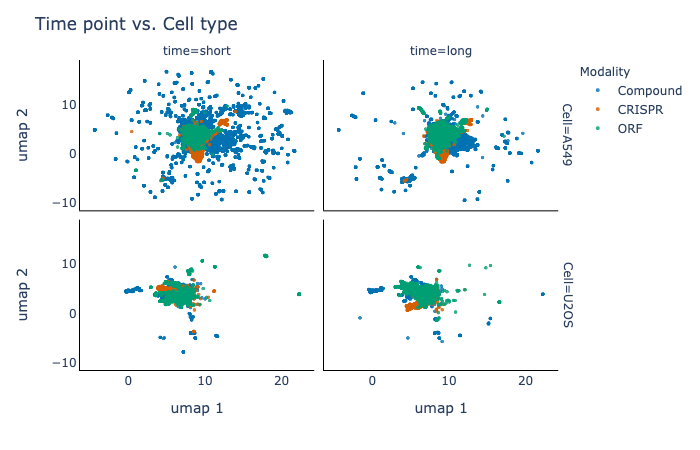

In [6]:
# time point and cell type

fig = px.scatter(data_frame=X_embedded_df,
                 x='umap 1',
                 y='umap 2',
                 color='Modality',
                 facet_col='time',
                 facet_row='Cell',
                 opacity=0.8,
                 category_orders={"Cell": ["A549", "U2OS"],
                                  "time": ["short", "long"],
                                  "Modality": ["Compound", "CRISPR", "ORF"]},
                 color_discrete_map=color_discrete_map)
fig.update_traces(marker=dict(size=4))
fig.update_layout(title='Time point vs. Cell type',
                  xaxis1=dict(title='umap 1', linecolor = "#000000"),
                  xaxis2=dict(title='umap 1', linecolor = "#000000"),
                  xaxis3=dict(linecolor = "#000000"),
                  xaxis4=dict(linecolor = "#000000"),
                  yaxis1=dict(title='umap 2', linecolor = "#000000"),
                  yaxis2=dict(linecolor = "#000000"),
                  yaxis3=dict(title='umap 2', linecolor = "#000000"),
                  yaxis4=dict(linecolor = "#000000"),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show("png")
fig.write_image(f'figures/4.umap_time_cell_type.png', width=640, height=480, scale=2)

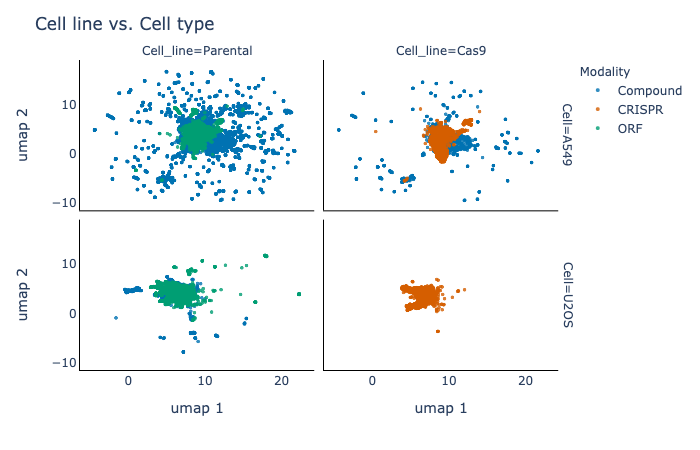

In [7]:
fig = px.scatter(data_frame=X_embedded_df,
                 x='umap 1',
                 y='umap 2',
                 color='Modality',
                 facet_col='Cell_line',
                 facet_row='Cell',
                 opacity=0.8,
                 category_orders={"Cell": ["A549", "U2OS"],
                                  "Cell_line": ["Parental", "Cas9"],
                                  "Modality": ["Compound", "CRISPR", "ORF"]},
                 color_discrete_map=color_discrete_map)
fig.update_traces(marker=dict(size=4))
fig.update_layout(title='Cell line vs. Cell type',
                  xaxis1=dict(title='umap 1', linecolor = "#000000"),
                  xaxis2=dict(title='umap 1', linecolor = "#000000"),
                  xaxis3=dict(linecolor = "#000000"),
                  xaxis4=dict(linecolor = "#000000"),
                  yaxis1=dict(title='umap 2', linecolor = "#000000"),
                  yaxis2=dict(linecolor = "#000000"),
                  yaxis3=dict(title='umap 2', linecolor = "#000000"),
                  yaxis4=dict(linecolor = "#000000"),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show("png")
fig.write_image(f'figures/4.umap_cell_line_cell_type.png', width=640, height=480, scale=2)

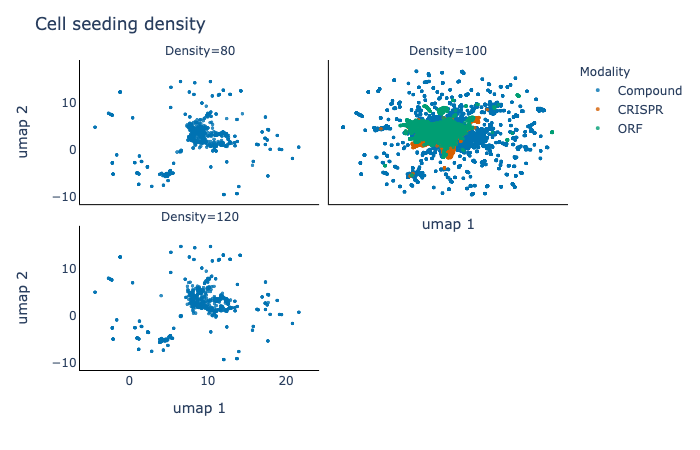

In [8]:
fig = px.scatter(data_frame=X_embedded_df,
                 x='umap 1',
                 y='umap 2',
                 color='Modality',
                 facet_col='Density',
                 facet_col_wrap=2,
                 opacity=0.8,
                 category_orders={"Density": [80, 100, 120],
                                  "Modality": ["Compound", "CRISPR", "ORF"]},
                 color_discrete_map=color_discrete_map)
fig.update_traces(marker=dict(size=4))
fig.update_layout(title='Cell seeding density',
                  xaxis1=dict(title='umap 1', linecolor = "#000000"),
                  xaxis3=dict(linecolor = "#000000"),
                  xaxis4=dict(title='umap 1', linecolor = "#000000"),
                  yaxis1=dict(title='umap 2', linecolor = "#000000"),
                  yaxis3=dict(title='umap 2', linecolor = "#000000"),
                  yaxis4=dict(linecolor = "#000000"),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show("png")
fig.write_image(f'figures/4.umap_density.png', width=640, height=480, scale=2)

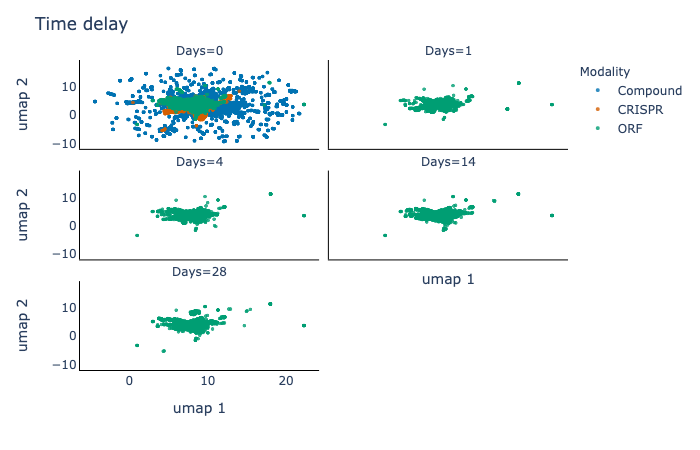

In [9]:
fig = px.scatter(data_frame=X_embedded_df,
                 x='umap 1',
                 y='umap 2',
                 color='Modality',
                 facet_col='Days',
                 facet_col_wrap=2,
                 opacity=0.8,
                 category_orders={"Days": [0, 1, 4, 14, 28],
                                  "Modality": ["Compound", "CRISPR", "ORF"]},
                 color_discrete_map=color_discrete_map)
fig.update_traces(marker=dict(size=4))
fig.update_layout(title='Time delay',
                  xaxis1=dict(title='umap 1', linecolor = "#000000"),
                  xaxis3=dict(linecolor = "#000000"),
                  xaxis4=dict(title='umap 1', linecolor = "#000000"),
                  xaxis5=dict(linecolor = "#000000"),
                  xaxis6=dict(linecolor = "#000000"),
                  yaxis1=dict(title='umap 2', linecolor = "#000000"),
                  yaxis3=dict(title='umap 2', linecolor = "#000000"),
                  yaxis4=dict(linecolor = "#000000"),
                  yaxis5=dict(title='umap 2', linecolor = "#000000"),
                  yaxis6=dict(linecolor = "#000000"),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show("png")
fig.write_image(f'figures/4.umap_time_delay.png', width=640, height=480, scale=2)

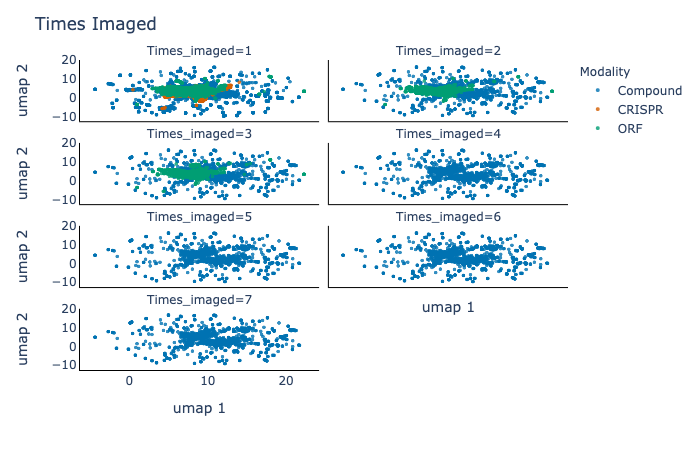

In [10]:
fig = px.scatter(data_frame=X_embedded_df,
                 x='umap 1',
                 y='umap 2',
                 color='Modality',
                 facet_col='Times_imaged',
                 facet_col_wrap=2,
                 opacity=0.8,
                 category_orders={"Times_imaged": [1, 2, 3, 4, 5, 6, 7],
                                  "Modality": ["Compound", "CRISPR", "ORF"]},
                 color_discrete_map=color_discrete_map)
fig.update_traces(marker=dict(size=4))
fig.update_layout(title='Times Imaged',
                  xaxis1=dict(title='umap 1', linecolor = "#000000"),
                  xaxis3=dict(linecolor = "#000000"),
                  xaxis4=dict(title='umap 1', linecolor = "#000000"),
                  xaxis5=dict(linecolor = "#000000"),
                  xaxis6=dict(linecolor = "#000000"),
                  xaxis7=dict(linecolor = "#000000"),
                  xaxis8=dict(linecolor = "#000000"),
                  yaxis1=dict(title='umap 2', linecolor = "#000000"),
                  yaxis3=dict(title='umap 2', linecolor = "#000000"),
                  yaxis4=dict(linecolor = "#000000"),
                  yaxis5=dict(title='umap 2', linecolor = "#000000"),
                  yaxis6=dict(linecolor = "#000000"),
                  yaxis7=dict(title='umap 2', linecolor = "#000000"),
                  yaxis8=dict(linecolor = "#000000"),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show("png")
fig.write_image(f'figures/4.umap_times_imaged.png', width=640, height=480, scale=2)

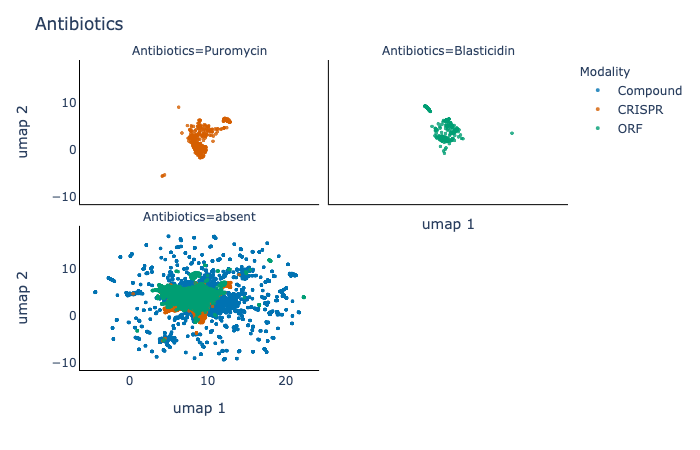

In [11]:
fig = px.scatter(data_frame=X_embedded_df,
                 x='umap 1',
                 y='umap 2',
                 color='Modality',
                 facet_col='Antibiotics',
                 facet_col_wrap=2,
                 opacity=0.8,
                 category_orders={"Antibiotics": ["Puromycin", "Blasticidin", "absent"],
                                  "Modality": ["Compound", "CRISPR", "ORF"]},
                 color_discrete_map=color_discrete_map)
fig.update_traces(marker=dict(size=4))
fig.update_layout(title='Antibiotics',
                  xaxis1=dict(title='umap 1', linecolor = "#000000"),
                  xaxis3=dict(linecolor = "#000000"),
                  xaxis4=dict(title='umap 1', linecolor = "#000000"),
                  yaxis1=dict(title='umap 2', linecolor = "#000000"),
                  yaxis3=dict(title='umap 2', linecolor = "#000000"),
                  yaxis4=dict(linecolor = "#000000"),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show("png")
fig.write_image(f'figures/4.umap_antibiotics.png', width=640, height=480, scale=2)